In [46]:
# Author: Arthur Prigent
# Email: aprigent@geomar.de

#### DATA ####
# https://downloads.psl.noaa.gov/Datasets/
from functions import *
    
   

# Last update 

In [47]:
print(str(now)[:16])

2021-06-18 08:51


# Read SST data 

In [48]:
path_oi_wk = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/'
(ssta_atl3_norm_oi_wk,ssta_aba_norm_oi_wk,
 ssta_nino34_norm_oi_wk,ssta_dni_norm_oi_wk) = read_data_compute_anomalies_week(path_oi_wk)

In [49]:
path_data = 'https://psl.noaa.gov/thredds/dodsC/Datasets/COBE/sst.mon.mean.nc'
(ssta_atl3_norm_cobe,ssta_aba_norm_cobe,
 ssta_nino34_norm_cobe,ssta_dni_norm_cobe) = read_data_compute_anomalies(path_data)

In [50]:
path_oi = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.oisst.v2/'
(ssta_atl3_norm_oi,ssta_aba_norm_oi,
 ssta_nino34_norm_oi,ssta_dni_norm_oi) = read_data_compute_anomalies_oi(path_oi)

In [51]:
path_ersstv5 = 'https://psl.noaa.gov/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
(ssta_atl3_norm_ersst,ssta_aba_norm_ersst,
 ssta_nino34_norm_ersst,ssta_dni_norm_ersst) = read_data_compute_anomalies_ersstv5(path_ersstv5)

# Timeseries of SST anomalies

# Monthly data


# [COBE SST](https://psl.noaa.gov/data/gridded/data.cobe.html) | 1$^{\circ}$ x 1$^{\circ}$ | Monthly

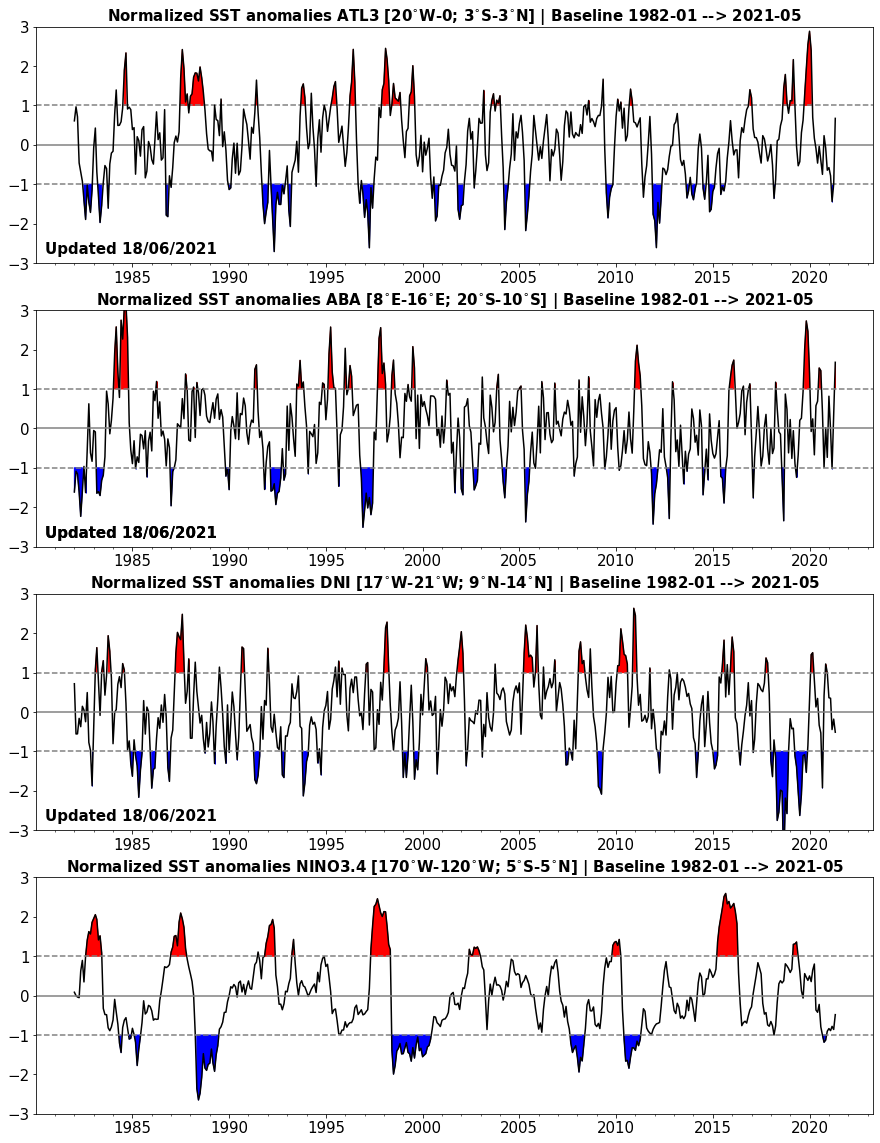

In [52]:
plot_anomalies(ssta_atl3_norm_cobe,ssta_aba_norm_cobe,ssta_nino34_norm_cobe,ssta_dni_norm_cobe)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Monthly

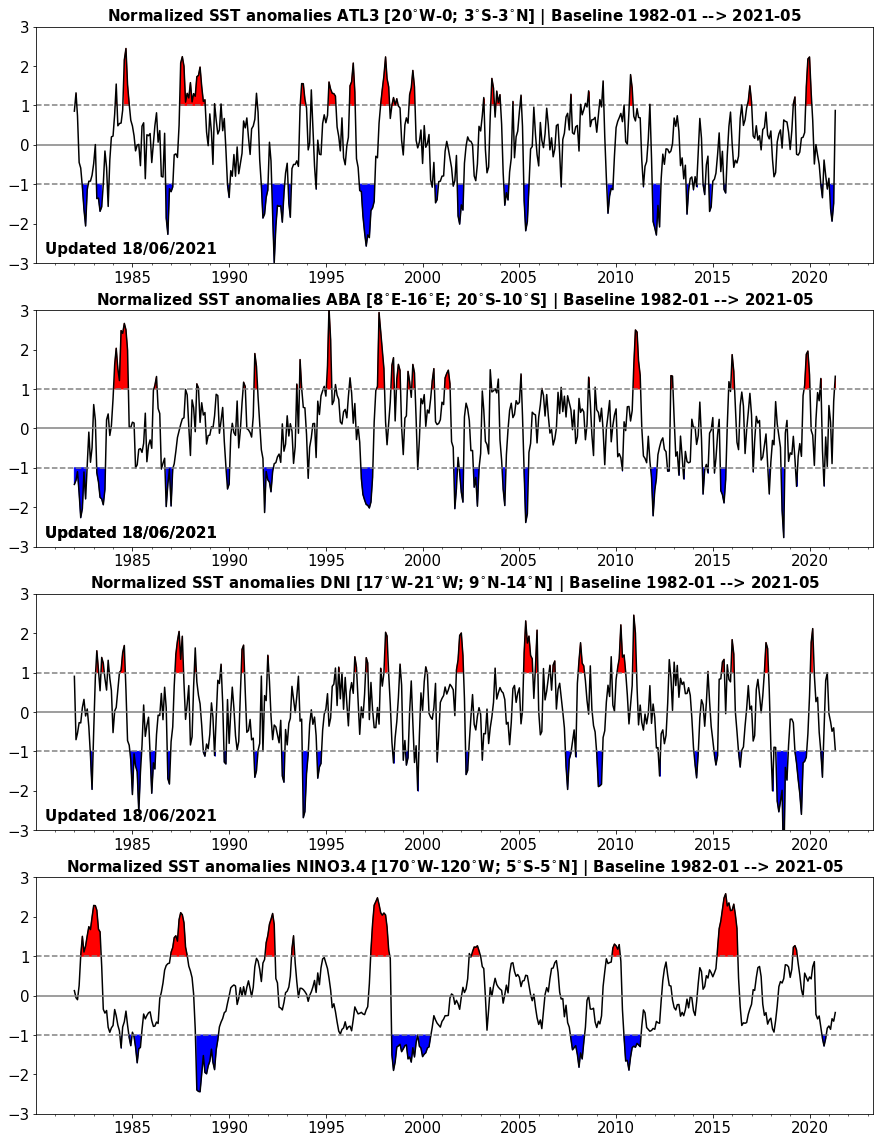

In [53]:
plot_anomalies(ssta_atl3_norm_oi,ssta_aba_norm_oi,ssta_nino34_norm_oi,ssta_dni_norm_oi)

# [ERSST V5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html) | 2$^{\circ}$ x 2$^{\circ}$ | Monthly

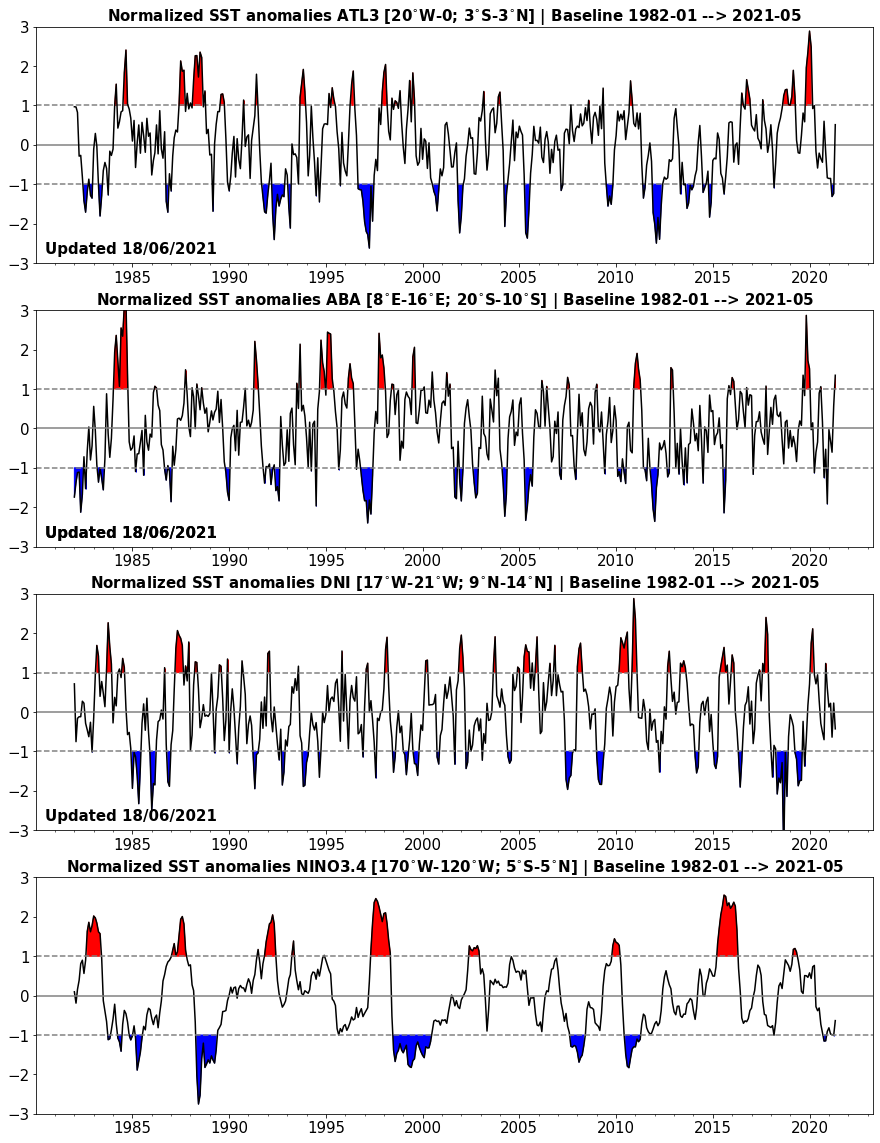

In [54]:
plot_anomalies(ssta_atl3_norm_ersst,ssta_aba_norm_ersst,ssta_nino34_norm_ersst,ssta_dni_norm_ersst)

# Weekly data

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly

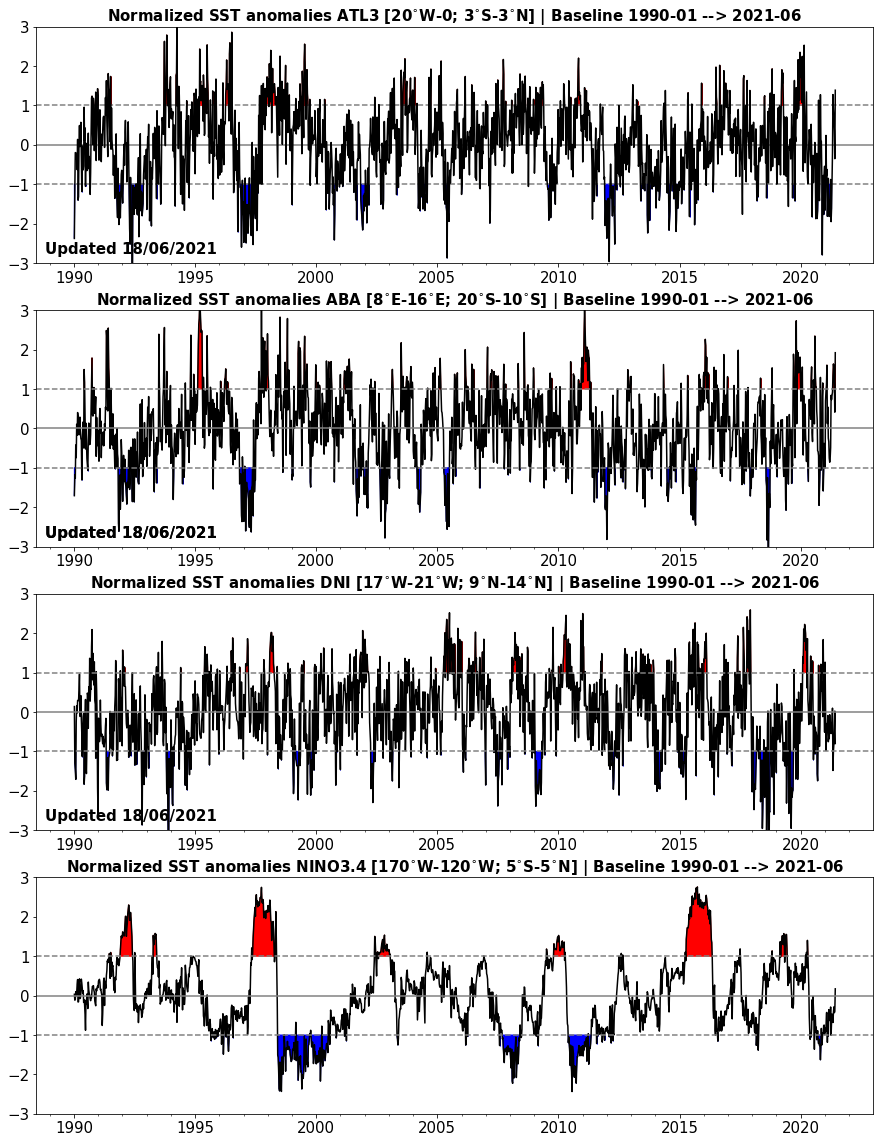

In [55]:
plot_anomalies(ssta_atl3_norm_oi_wk,ssta_aba_norm_oi_wk,ssta_nino34_norm_oi_wk,ssta_dni_norm_oi_wk)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly | ABA region only

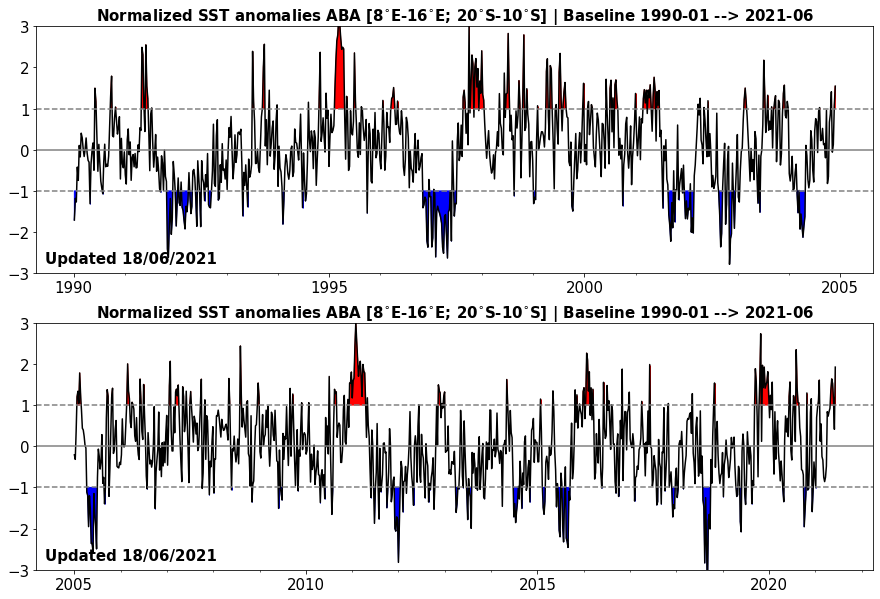

In [56]:
plot_anomalies_wk_aba(ssta_aba_norm_oi_wk)

# [OI SST v2](https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html) | 1$^{\circ}$ x 1$^{\circ}$ | Weekly | ATL3 region only

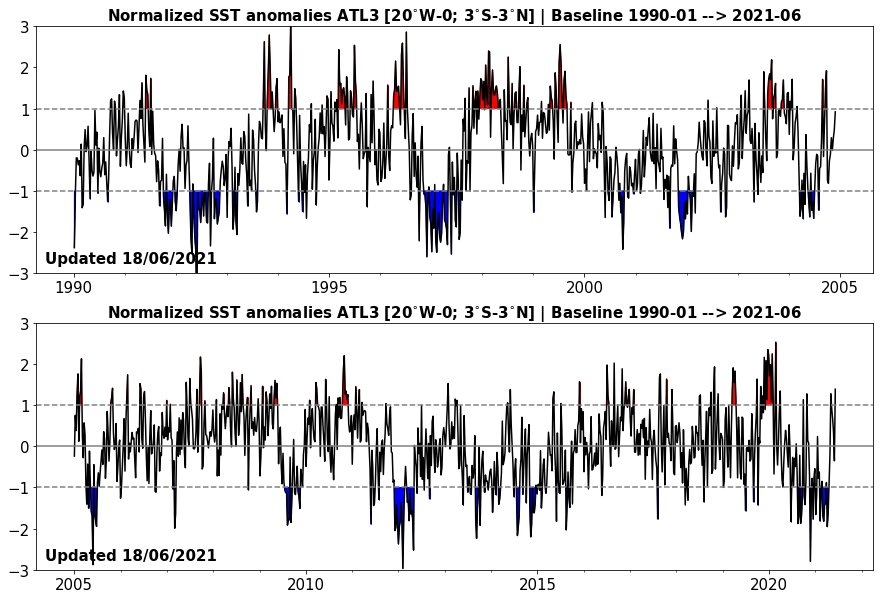

In [57]:
plot_anomalies_wk_atl3(ssta_atl3_norm_oi_wk)